In [1]:
import numpy as np
import glob
import csv
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import cv2
import time
from datetime import timedelta
from scipy import signal


# Creating the calibration matrix 

In [2]:
checkerboard_file_list = []
for name in glob.glob('/home/deep_cat/sdc-P4/camera_cal/calibration*'):
    checkerboard_file_list.append(name)
    
print(checkerboard_file_list)

['/home/deep_cat/sdc-P4/camera_cal/calibration7.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration18.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration17.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration4.png', '/home/deep_cat/sdc-P4/camera_cal/calibration19.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration20.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration12.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration1.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration8.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration11.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration15.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration2.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration6.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration9.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration10.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration5.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration13.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration16.jpg', '/home/deep_cat/sdc-P4/camera_cal/c

True /home/deep_cat/sdc-P4/camera_cal/calibration7.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration18.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration17.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration4.png
True /home/deep_cat/sdc-P4/camera_cal/calibration19.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration20.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration12.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration1.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration8.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration11.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration15.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration2.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration6.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration9.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration10.jpg
False /home/deep_cat/sdc-P4/camera_cal/calibration5.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration13.jpg
True /home/deep_cat/sdc-P4/camera_cal/calibration16.j

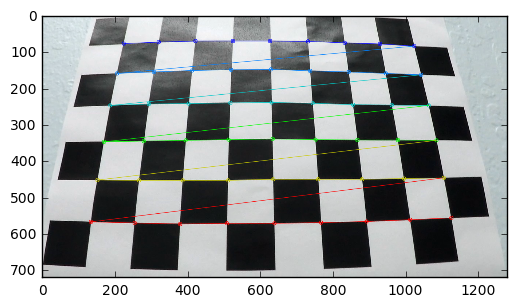

In [3]:
# this process creates the checkerboard points needed to 
# develop the calibration matrix

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for path in checkerboard_file_list: 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print(ret, path)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [4]:
# this function generates the calibration matrix needed to undistort each future image from the camera

ret, mtx,dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Image processing

In [5]:
## Gradient thresholding functions 
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
   
    
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  
       
    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1  
    
    if orient == 'x': 
        return sx_binary
        
    if orient == 'y':
        return sy_binary
    
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 6) Create a binary mask where mag thresholds are met
    # 7) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # abs_sobel_x = np.absolute(sobel_x)
    # abs_sobel_y = np.absolute(sobel_y)
    
    # scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    # scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
    magnitude = np.sqrt((sobel_x**2) + (sobel_y**2))
    scale_factor = np.max(magnitude)/255
    magnitude=  (magnitude/scale_factor).astype(np.uint8)
    
    mag_binary= np.zeros_like(magnitude)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1  
    return mag_binary


# thresholding the direction 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# color thresholding function 
def hls_select(img, thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output =  np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_output

In [6]:
# image for calibrating the warping function
img = mpimg.imread('/home/deep_cat/sdc-P4/test_images/undistorted_test7.jpg') 


# this takes a road image and transforms it to perspective view
img_size = (img.shape[1], img.shape[0])
x_offset = 200
y_offset = 20
 # manually picked points 
# src = np.float32([(570,480), (754, 480), (1084, 675), (310, 675)]) 
src = np.float32([(604,450), (672,450), (1100,683), (330,683)])
dst = np.float32([[x_offset, y_offset], 
                  [img_size[0]-x_offset, y_offset], 
                  [img_size[0]-x_offset, img_size[1]-y_offset], 
                  [x_offset, img_size[1]-y_offset]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src) # used later to lay the the polynomials back into the image


In [14]:
def find_lanes(img):
    # takes the combined_binary image and 
    # 1. transforms it
    # 2. Finds lanes
    # 3. re-projects the lanes on the road
    

    warped = cv2.warpPerspective(img, M, img_size)

    
    # finding the lanes
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    peaks = signal.find_peaks_cwt(histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100]) 
    leftyvals = []
    leftxvals = []
    rightxvals = []
    rightyvals = []
    window_buffer = 50

    left_lane_window = np.min(peaks)
    right_lane_window = np.max(peaks)
    for y in range(0, warped.shape[0]):
        for x in range(0, warped.shape[1]):
            pixel_value = warped[y,x]
            if x > left_lane_window - window_buffer and x < left_lane_window + window_buffer : 
                if pixel_value == 1:
                    leftxvals.append(x)
                    leftyvals.append(y)
            if x > right_lane_window - window_buffer and x < right_lane_window + window_buffer : 
                if pixel_value == 1:
                    rightxvals.append(x)   
                    rightyvals.append(y)






    # finding the polylines
    
    leftyvals = np.asarray(leftyvals)
    leftxvals = np.asarray(leftxvals)
    rightyvals = np.asarray(rightyvals)
    rightxvals = np.asarray(rightxvals)

    # synthetic yvals to make it even
    yvals = np.linspace(0, 100, num=101)*7.2

    # for the left lane 
    left_fit_coefficients = np.polyfit(leftyvals, leftxvals, 2) # creates the coeeficients
    left_fitx = left_fit_coefficients[0] * yvals ** 2 + left_fit_coefficients[1] * yvals + left_fit_coefficients[2]

    # for the right lane 
    right_fit_coefficients = np.polyfit(rightyvals, rightxvals,2) # creates the coeeficients
    right_fitx = right_fit_coefficients[0] * yvals ** 2 + right_fit_coefficients[1] * yvals + right_fit_coefficients[2]
    




    # drawing the polylines on original image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    

    
    return newwarp
    

# Image Pipeline


In [8]:
def process_image(image):
    original = np.copy(image)
    
    # Undistort the frame
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    
    # gradients and thresholds
    ksize = 3
    sobelx_binary = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh=(20,100))
   
    # color thresholding
    s_binary = hls_select(image, thresh = (100,255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1)] = 1

      
  
    newwarp = find_lanes(combined_binary)
    
    # adding the lanes to the original
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0) # this wanted the pre-pipeline image for some reason 
    
    
    return result

In [9]:
# test image 
test6 = mpimg.imread('/home/deep_cat/sdc-P4/test_images/test6.jpg') ## note: didn't use the cv2 import here

final =process_image(test6)

/home/deep_cat/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


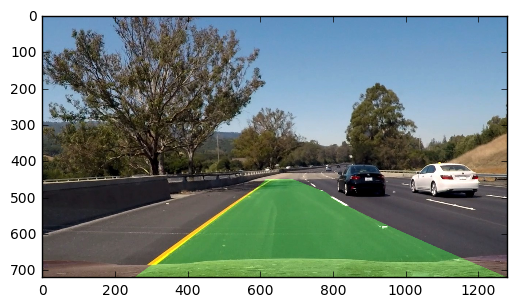

In [10]:
plt.imshow(final)

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
# running the pipeline on the video
output_name = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
output_clip.write_videofile(output_name, audio= False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [26:12<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [13]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output_name))